In [69]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from collections import Counter
import string
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

In [70]:
train_file_path = 'train.csv'
test_file_path = 'test.csv'

# Read the CSV file into a DataFrame.
# If the file does not have headers, specify header=None and assign a column name.
df = pd.read_csv(train_file_path, header=None, names=['sentence'])
df_test = pd.read_csv(test_file_path, header=None, names=['sentence'])

#### EDA on train dataset

In [71]:
# DataFrame structure and general info
print("Training DataFrame Info:")
df.info()

# Display summary statistics
print("\nDataFrame Summary Statistics:")
print(df.describe(include='all'))

# Check the first few rows of the DataFrame
print("\nFirst Few Rows:")
print(df.head())

Training DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52499 entries, 0 to 52498
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  52499 non-null  object
dtypes: object(1)
memory usage: 410.3+ KB

DataFrame Summary Statistics:
            sentence
count          52499
unique         51134
top     [('.', '.')]
freq              44

First Few Rows:
                                            sentence
0  [('03/01/2001', 'NUM'), ('01:35', 'NUM'), ('PM...
1  [('The', 'DET'), ('industry', 'NOUN'), ('has',...
2  [('Love', 'VERB'), ('this', 'DET'), ('place', ...
3  [('This', 'DET'), ('problem', 'NOUN'), ('of', ...
4  [('Esso', 'PROPN'), ('said', 'VERB'), ('0', 'X...


#### EDA on test dataset

In [72]:
# DataFrame structure and general info
print("Testing DataFrame Info:")
df_test.info()

# Display summary statistics
print("\nDataFrame Summary Statistics:")
print(df_test.describe(include='all'))

# Check the first few rows of the DataFrame
print("\nFirst Few Rows:")
print(df_test.head())

df

Testing DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65625 entries, 0 to 65624
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  65625 non-null  object
dtypes: object(1)
memory usage: 512.8+ KB

DataFrame Summary Statistics:
            sentence
count          65625
unique         63760
top     [('.', '.')]
freq              53

First Few Rows:
                                            sentence
0                                  [('DF', 'PROPN')]
1  [('03/01/2001', 'NUM'), ('01:35', 'NUM'), ('PM...
2  [('The', 'DET'), ('industry', 'NOUN'), ('has',...
3  [('Love', 'VERB'), ('this', 'DET'), ('place', ...
4  [('This', 'DET'), ('problem', 'NOUN'), ('of', ...


,sentence
0,"[('03/01/2001', 'NUM'), ('01:35', 'NUM'), ('PM..."
1,"[('The', 'DET'), ('industry', 'NOUN'), ('has',..."
2,"[('Love', 'VERB'), ('this', 'DET'), ('place', ..."
3,"[('This', 'DET'), ('problem', 'NOUN'), ('of', ..."
4,"[('Esso', 'PROPN'), ('said', 'VERB'), ('0', 'X..."
...,...
52494,"[('Superstition', 'NOUN'), ('has', 'VERB'), ('..."
52495,"[('You', 'PRON'), ('now', 'ADV'), ('should', '..."
52496,"[('But', 'CONJ'), ('in', 'ADP'), ('the', 'DET'..."
52497,"[('Specifically', 'ADV'), (',', 'PUNCT'), ('Je..."


#### EDA: Comparision between train and test dataset


Length of Train Dataset before dropping duplicates: 52499
Length of Test Dataset before dropping duplicates: 65625

Length of Train Dataset after dropping duplicates: 51134
Length of Test Dataset after dropping duplicates: 63760

Unique to Train: 0
Unique to Test: 12626
Common rows: 51134


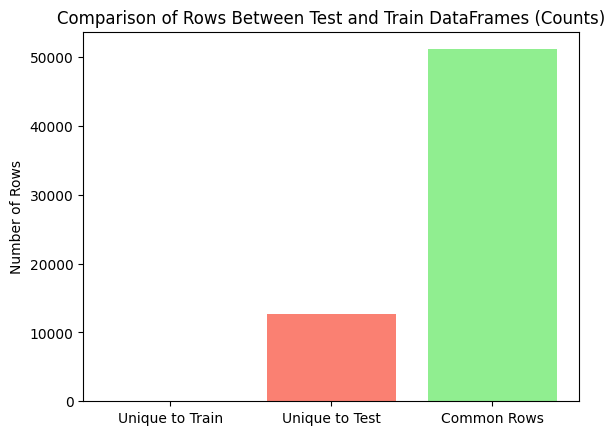


Percentage of Unique to Train: 0.00%
Percentage of Unique to Test: 19.80%
Percentage of Common Rows: 80.20%


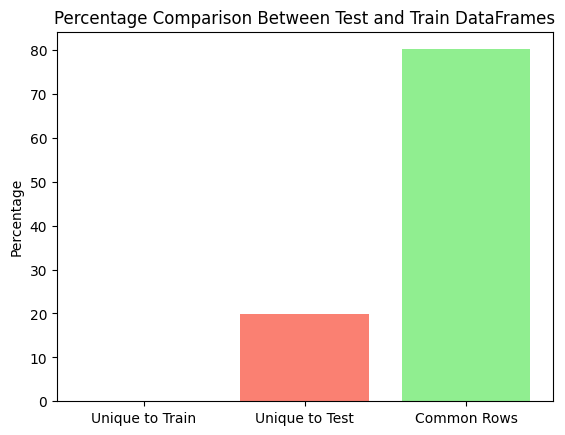

Train dataset assertion passed ✅
Test dataset assertion passed ✅
Total row counts assertion passed ✅


In [73]:
# Drop Duplicates and Compare
print("\nLength of Train Dataset before dropping duplicates:", len(df))
print("Length of Test Dataset before dropping duplicates:", len(df_test))

df = df.drop_duplicates(subset=['sentence'])
df_test = df_test.drop_duplicates(subset=['sentence'])

print("\nLength of Train Dataset after dropping duplicates:", len(df))
print("Length of Test Dataset after dropping duplicates:", len(df_test))

unique_to_df1 = df[~df['sentence'].isin(df_test['sentence'])]
unique_to_df2 = df_test[~df_test['sentence'].isin(df['sentence'])]
common_rows = pd.merge(df, df_test, on='sentence')

# Create counts for visualization
counts = {
    'Unique to Train': len(unique_to_df1),
    'Unique to Test': len(unique_to_df2),
    'Common Rows': len(common_rows)
}

print("\nUnique to Train:", len(unique_to_df1))
print("Unique to Test:", len(unique_to_df2))
print("Common rows:", len(common_rows))

# Plotting comparison for counts
plt.bar(counts.keys(), counts.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Comparison of Rows Between Test and Train DataFrames (Counts)")
plt.ylabel("Number of Rows")
plt.show()

# Calculate percentages for better insight
#total_rows = len(df) + len(df_test) [This is incorrect as we're counting the common rows twice]
total_rows = counts["Unique to Train"] + counts["Unique to Test"] + counts["Common Rows"]
percentages = {key: (value / total_rows) * 100 for key, value in counts.items()}

print("\nPercentage of Unique to Train: {:.2f}%".format(percentages['Unique to Train']))
print("Percentage of Unique to Test: {:.2f}%".format(percentages['Unique to Test']))
print("Percentage of Common Rows: {:.2f}%".format(percentages['Common Rows']))

# Plotting percentage comparison
plt.bar(percentages.keys(), percentages.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Percentage Comparison Between Test and Train DataFrames")
plt.ylabel("Percentage")
plt.show()

# Assertions for sanity checks
assert len(df) == len(unique_to_df1) + len(common_rows), "Mismatch in Train dataset counts!"
print("Train dataset assertion passed ✅")

assert len(df_test) == len(unique_to_df2) + len(common_rows), "Mismatch in Test dataset counts!"
print("Test dataset assertion passed ✅")

assert sum(counts.values()) == len(df) + len(df_test) - len(common_rows), "Total row counts assertion passed ✅"
print("Total row counts assertion passed ✅")



#### Sentence Parsing
Converting the given sentence string to a list of tuples.

In [74]:
df['parsed_sentence'] = df['sentence'].apply(lambda x: ast.literal_eval(x))
df_test['parsed_sentence'] = df_test['sentence'].apply(lambda x: ast.literal_eval(x))

/var/folders/mz/ywg60v213710yk8053f7h4k00000gn/T/ipykernel_35591/1339998295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['parsed_sentence'] = df['sentence'].apply(lambda x: ast.literal_eval(x))


#### EDA on train dataset

In [75]:
num_sentences = len(df)
print("\nTotal number of sentences:", num_sentences)
# Display DataFrame information
print("\nDataFrame Info:")
print(df.info())


Total number of sentences: 51134

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 51134 entries, 0 to 52498
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentence         51134 non-null  object
 1   parsed_sentence  51134 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None


In [76]:
# print the first row with all columns
print("After converting from string to list of tuples, the parsed sentence in first row:")
print(df['parsed_sentence'].iloc[0])
print(type(df['parsed_sentence'].iloc[0]))
# print more info about the column parsed. like, the datatype and stuff
# print(df['parsed'].apply(type).value_counts())
print("\nFirst value in first row of the parsed column:")
print(df['parsed_sentence'].iloc[0][0])
print(type(df['parsed_sentence'].iloc[0][0]))

After converting from string to list of tuples, the parsed sentence in first row:
[('03/01/2001', 'NUM'), ('01:35', 'NUM'), ('PM', 'NOUN')]
<class 'list'>

First value in first row of the parsed column:
('03/01/2001', 'NUM')
<class 'tuple'>


In [77]:
# Calculate sentence lengths (number of word-tag pairs per sentence)
df['sentence_length'] = df['parsed_sentence'].apply(lambda sentence: len(sentence))
print("\nSentence length statistics:")
print(df['sentence_length'].describe())

print("\nLength of sentences for first few rows:")
print(df['sentence_length'].head())


Sentence length statistics:
count    51134.000000
mean        20.555501
std         13.278339
min          1.000000
25%         11.000000
50%         18.000000
75%         28.000000
max        180.000000
Name: sentence_length, dtype: float64

Length of sentences for first few rows:
0     3
1    10
2     4
3    23
4    10
Name: sentence_length, dtype: int64


/var/folders/mz/ywg60v213710yk8053f7h4k00000gn/T/ipykernel_35591/2767257790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentence_length'] = df['parsed_sentence'].apply(lambda sentence: len(sentence))


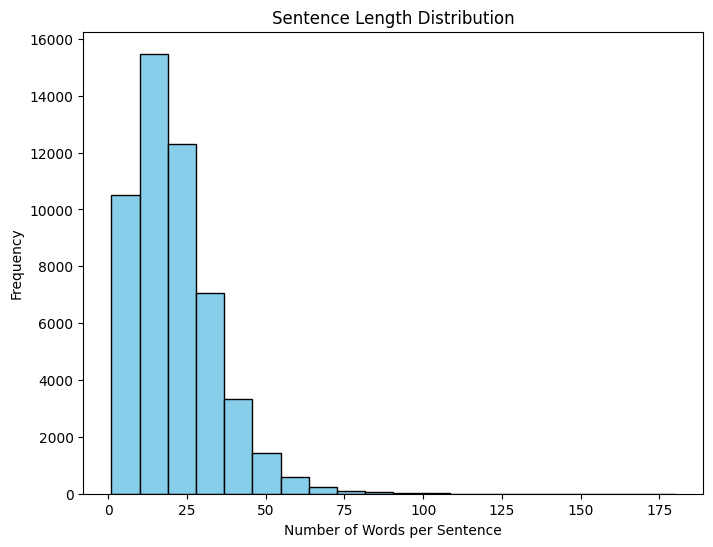

In [78]:
# Visualize the distribution of sentence lengths
plt.figure(figsize=(8, 6))
df['sentence_length'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

#### Separating word and corresponding tag pair for each word in all sentences 

In [79]:
# Create a list of dictionaries where each dictionary represents a word-tag pair.
records = []
for sentence in df['parsed_sentence']:
    for word, tag in sentence:
        records.append({'word': word, 'tag': tag})

# Create a new DataFrame from the records.
df_words = pd.DataFrame(records)
print(df_words)

               word    tag
0        03/01/2001    NUM
1             01:35    NUM
2                PM   NOUN
3               The    DET
4          industry   NOUN
...             ...    ...
1051080           .  PUNCT
1051081           B    ADJ
1051082           &  CCONJ
1051083           w    ADJ
1051084           .  PUNCT

[1051085 rows x 2 columns]


#### EDA: word-tag distribution

In [80]:
# Check basic information and types
print("Dataset Info:")
df_words.info()

# Summary statistics
print("\nDataset Summary Statistics:")
print(df_words.describe(include='all'))

# Check for missing values
print("\nMissing Values:")
print(df_words.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051085 entries, 0 to 1051084
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   word    1051085 non-null  object
 1   tag     1051085 non-null  object
dtypes: object(2)
memory usage: 16.0+ MB

Dataset Summary Statistics:
           word      tag
count   1051085  1051085
unique    58110       21
top         the     NOUN
freq      54411   239116

Missing Values:
word    0
tag     0
dtype: int64


Length of tag distribution: 21

Tag Frequency Distribution:
tag
NOUN     239116
VERB     151350
ADP      124875
DET      115502
.         94258
ADJ       76492
ADV       48887
PRON      48510
CONJ      27227
PUNCT     23089
PROPN     18938
PRT       18667
NUM       16778
X         13147
AUX       12563
PART       7514
CCONJ      6446
SCONJ      3666
_          2643
INTJ        712
SYM         705
Name: count, dtype: int64


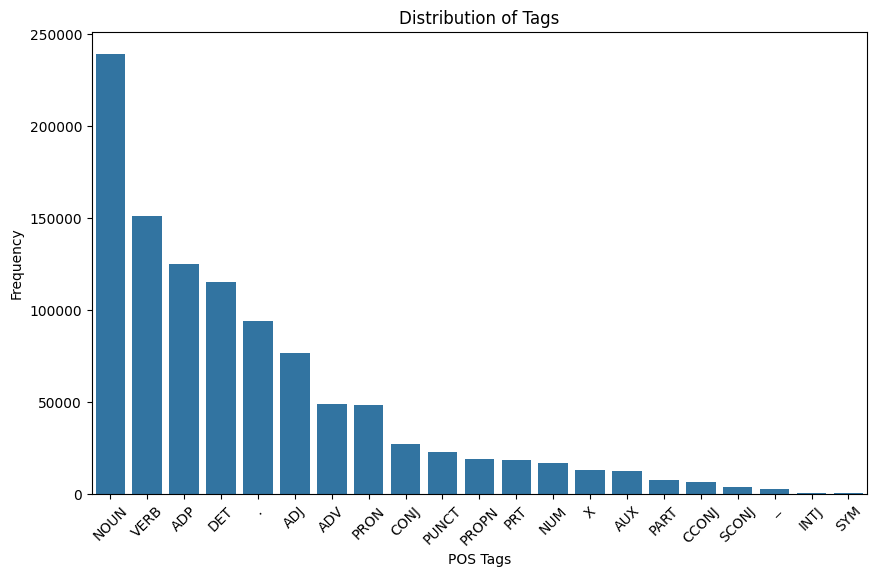

In [81]:
# Count the frequency of each tag
tag_distribution = df_words['tag'].value_counts()
print("Length of tag distribution:", len(tag_distribution))
print("\nTag Frequency Distribution:")
print(tag_distribution)

# Plot the distribution of tags
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=tag_distribution.index, y=tag_distribution.values)
plt.title("Distribution of Tags")
plt.xlabel("POS Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()



Top 10 Most Frequent Words:
word
the     54411
,       48728
.       42284
of      31048
and     24549
to      23850
a       19556
in      17670
is      10267
that     9427
Name: count, dtype: int64


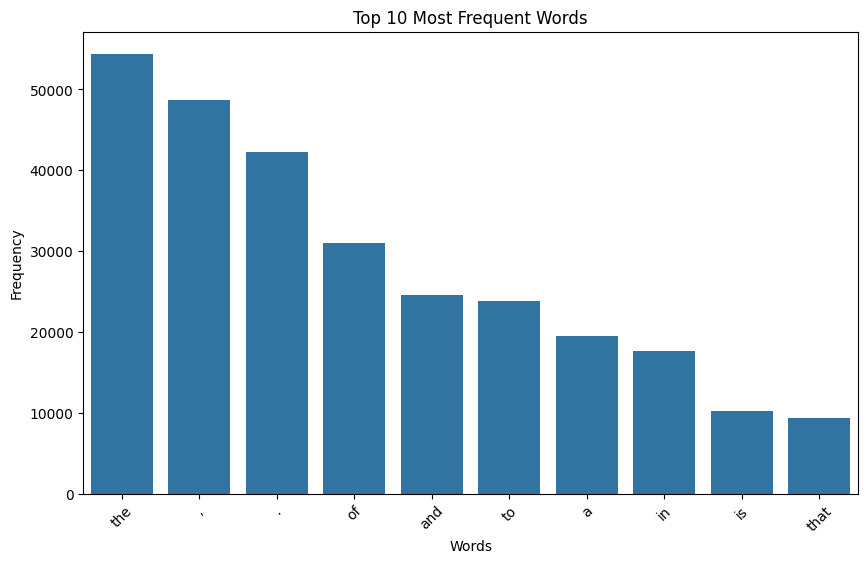

In [82]:
# Count the frequency of words
word_frequency = df_words['word'].value_counts()
print("\nTop 10 Most Frequent Words:")
print(word_frequency.head(10))

# Plot the top 10 most frequent words
plt.figure(figsize=(10, 6))
sns.barplot(x=word_frequency.head(10).index, y=word_frequency.head(10).values)
plt.title("Top 10 Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


### Step-2. Pre-Processing

#### Text Cleaning
- Converting to Lowercase
- Removing URLs if any using regex library
- Removing non-word and non-whitespace characters: punctuations marks, symbols, other special characters

In [83]:
def clean_word(word):
    # Convert to lowercase
    word = word.lower()
    
    # Remove URLs
    word = re.sub(r'http\S+|www\S+|https\S+', '', word)
    
    # Remove non-word and non-whitespace characters
    word = re.sub(r'[^\w\s]', '', word)
    
    # # Remove alphanumeric words containing digits but leave words like underscores
    # word = re.sub('\b\w*\d\w*\b', '', word)
    
    # Remove words that consist only of underscores
    if re.match(r'^\_+$', word):
        return None  # Remove this word if it consists of only underscores

    # Return cleaned word if it's not purely numeric and not empty
    return word if word else None

def clean_sentence(sentence):
    cleaned_sentence = []
    for word, tag in sentence:
        # Only clean the word, keep the tag unchanged
        cleaned_word = clean_word(word)
        if cleaned_word and tag != 'X' and tag != 'NUM' and tag != '_' and tag != 'SYM':  # Keep valid cleaned words and remove 'X' tags
            cleaned_sentence.append((cleaned_word, tag))
    return cleaned_sentence

# Apply the updated cleaning function to the parsed sentences
df['parsed_sentence'] = df['parsed_sentence'].apply(clean_sentence)
# Doing it on test dataset also
df_test['parsed_sentence'] = df_test['parsed_sentence'].apply(clean_sentence)


/var/folders/mz/ywg60v213710yk8053f7h4k00000gn/T/ipykernel_35591/2861709635.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['parsed_sentence'] = df['parsed_sentence'].apply(clean_sentence)


In [84]:
test_word = clean_word("65")
test_word

'65'

In [85]:
# Extract all words and tags from the parsed sentences
all_words = [word for sentence in df['parsed_sentence'] for word, _ in sentence]
all_tags = [tag for sentence in df['parsed_sentence'] for __, tag in sentence]
print("Total words: ", len(all_words), "Total tags: ", len(all_tags))
# Get unique words and tags
unique_words = set(all_words)
unique_tags = set(all_tags)

print(f"Total Unique Words: {len(unique_words)}")
print(f"Total Unique Tags: {len(unique_tags)}")
print("Few Unique Words:", list(unique_words)[:10])
print("\nFew Unique Tags:", list(unique_tags))


Total words:  899541 Total tags:  899541
Total Unique Words: 45362
Total Unique Tags: 15
Few Unique Words: ['privet', 'abuses', 'planetarium', 'balkanized', 'kitchen', 'emanuel', 'orgasm', 'peng', 'abilities', 'giants']

Few Unique Tags: ['DET', 'ADP', 'VERB', 'INTJ', 'PRON', 'ADJ', 'PRT', 'PART', 'ADV', 'AUX', 'NOUN', 'PROPN', 'SCONJ', 'CONJ', 'CCONJ']


In [86]:
# Create dictionaries mapping words and tags to indices
word_to_index = {word: idx for idx, word in enumerate(sorted(unique_words))}
tag_to_index = {tag: idx for idx, tag in enumerate(sorted(unique_tags))}

print("\nSample Word to Index Mapping:", list(word_to_index.items())[:10])
print("\nSample Tag to Index Mapping:", list(tag_to_index.items()))


Sample Word to Index Mapping: [('0002', 0), ('000s', 1), ('0025in', 2), ('0080in', 3), ('01feb02', 4), ('01mvm', 5), ('027', 6), ('03', 7), ('03m', 8), ('05', 9)]

Sample Tag to Index Mapping: [('ADJ', 0), ('ADP', 1), ('ADV', 2), ('AUX', 3), ('CCONJ', 4), ('CONJ', 5), ('DET', 6), ('INTJ', 7), ('NOUN', 8), ('PART', 9), ('PRON', 10), ('PROPN', 11), ('PRT', 12), ('SCONJ', 13), ('VERB', 14)]


#### Stop word removal

In [87]:
# # Download stopwords if not already downloaded
# nltk.download('stopwords')

# # Define the stop words set
# stop_words = set(stopwords.words('english'))

In [88]:
# # Count the total stop words before removal
# total_stop_words_before = sum(
#     word.lower() in stop_words for sentence in df['parsed_sentence'] for word, _ in sentence
# )

# print(f"Total number of stop words before removal: {total_stop_words_before}")

In [89]:
# def remove_stop_words(sentence):
#     # Remove stop words from the sentence while keeping tags intact
#     return [(word, tag) for word, tag in sentence if word.lower() not in stop_words]

# # Apply the stop word removal function
# df['parsed_sentence'] = df['parsed_sentence'].apply(remove_stop_words)
# df_test['parsed_sentence'] = df_test['parsed_sentence'].apply(remove_stop_words)

In [90]:
# # Count the total stop words after removal
# total_stop_words_after = sum(
#     word.lower() in stop_words for sentence in df['parsed_sentence'] for word, _ in sentence
# )

# print(f"Total number of stop words after removal: {total_stop_words_after}")


#### Generating Vocabulary

In [91]:
from collections import defaultdict

# Extract unique tags and words from the parsed sentences to account all the unique tags and words
tags = set()
words = set()

for sentence in df['parsed_sentence']:
    for item in sentence:
        word, tag = item
        tags.add(tag)
        words.add(word)

tags = list(tags)
words = list(words)
print(len(words))

45362


In [97]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download necessary NLTK data
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("omw-1.4")

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to convert NLTK POS tag to WordNet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('V'):  # Verb
        return wordnet.VERB
    elif tag.startswith('N'):  # Noun
        return wordnet.NOUN
    return None  # Ignore other parts of speech

# Function to lemmatize words in a sentence based on their POS tags
def lemmatize_sentence(sentence):
    lemmatized_sentence = []
    for word, tag in sentence:
        wordnet_pos = get_wordnet_pos(tag)
        if wordnet_pos:
            lemmatized_word = lemmatizer.lemmatize(word, wordnet_pos)
            lemmatized_sentence.append((lemmatized_word, tag))
        else:
            lemmatized_sentence.append((word, tag))
    return lemmatized_sentence

#Before lemmatisation
# Display the first few rows to verify the changes
print("\nBefore lemmatization....")
print("First few rows of unlemmatised train dataset:")
print(df['parsed_sentence'].head())

print("\nFirst few rows of unlemmatized test dataset:")
print(df_test['parsed_sentence'].head())

# Apply lemmatization to the parsed sentences in the train and test datasets
df['parsed_sentence'] = df['parsed_sentence'].apply(lemmatize_sentence)
df_test['parsed_sentence'] = df_test['parsed_sentence'].apply(lemmatize_sentence)

# Display the first few rows to verify the changes
print("First few rows of lemmatized train dataset:")
print(df['parsed_sentence'].head())

print("\nFirst few rows of lemmatized test dataset:")
print(df_test['parsed_sentence'].head())

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/amit/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/amit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/amit/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Before lemmatization....
First few rows of unlemmatised train dataset:
0                                         [(pm, NOUN)]
1    [(the, DET), (industry, NOUN), (have, VERB), (...
2           [(love, VERB), (this, DET), (place, NOUN)]
3    [(this, DET), (problem, NOUN), (of, ADP), (the...
4    [(esso, PROPN), (say, VERB), (the, DET), (whit...
Name: parsed_sentence, dtype: object

First few rows of unlemmatized test dataset:
0                                        [(df, PROPN)]
1                                         [(pm, NOUN)]
2    [(the, DET), (industry, NOUN), (have, VERB), (...
3           [(love, VERB), (this, DET), (place, NOUN)]
4    [(this, DET), (problem, NOUN), (of, ADP), (the...
Name: parsed_sentence, dtype: object


/var/folders/mz/ywg60v213710yk8053f7h4k00000gn/T/ipykernel_35591/638780975.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['parsed_sentence'] = df['parsed_sentence'].apply(lemmatize_sentence)


First few rows of lemmatized train dataset:
0                                         [(pm, NOUN)]
1    [(the, DET), (industry, NOUN), (have, VERB), (...
2           [(love, VERB), (this, DET), (place, NOUN)]
3    [(this, DET), (problem, NOUN), (of, ADP), (the...
4    [(esso, PROPN), (say, VERB), (the, DET), (whit...
Name: parsed_sentence, dtype: object

First few rows of lemmatized test dataset:
0                                        [(df, PROPN)]
1                                         [(pm, NOUN)]
2    [(the, DET), (industry, NOUN), (have, VERB), (...
3           [(love, VERB), (this, DET), (place, NOUN)]
4    [(this, DET), (problem, NOUN), (of, ADP), (the...
Name: parsed_sentence, dtype: object


## EDA after preprocessing

In [102]:
df['parsed_sentence_length'] = df['parsed_sentence'].apply(lambda sentence: len(sentence))
df

/var/folders/mz/ywg60v213710yk8053f7h4k00000gn/T/ipykernel_35591/3670583534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['parsed_sentence_length'] = df['parsed_sentence'].apply(lambda sentence: len(sentence))


,sentence,parsed_sentence,sentence_length,parsed_sentence_length
0,"[('03/01/2001', 'NUM'), ('01:35', 'NUM'), ('PM...","[(pm, NOUN)]",3,1
1,"[('The', 'DET'), ('industry', 'NOUN'), ('has',...","[(the, DET), (industry, NOUN), (have, VERB), (...",10,8
2,"[('Love', 'VERB'), ('this', 'DET'), ('place', ...","[(love, VERB), (this, DET), (place, NOUN)]",4,3
3,"[('This', 'DET'), ('problem', 'NOUN'), ('of', ...","[(this, DET), (problem, NOUN), (of, ADP), (the...",23,22
4,"[('Esso', 'PROPN'), ('said', 'VERB'), ('0', 'X...","[(esso, PROPN), (say, VERB), (the, DET), (whit...",10,8
...,...,...,...,...
52494,"[('Superstition', 'NOUN'), ('has', 'VERB'), ('...","[(superstition, NOUN), (have, VERB), (often, A...",10,9
52495,"[('You', 'PRON'), ('now', 'ADV'), ('should', '...","[(you, PRON), (now, ADV), (should, AUX), (have...",30,23
52496,"[('But', 'CONJ'), ('in', 'ADP'), ('the', 'DET'...","[(but, CONJ), (in, ADP), (the, DET), (second, ...",44,36
52497,"[('Specifically', 'ADV'), (',', 'PUNCT'), ('Je...","[(specifically, ADV), (jeffs, PROPN), (is, AUX...",28,24


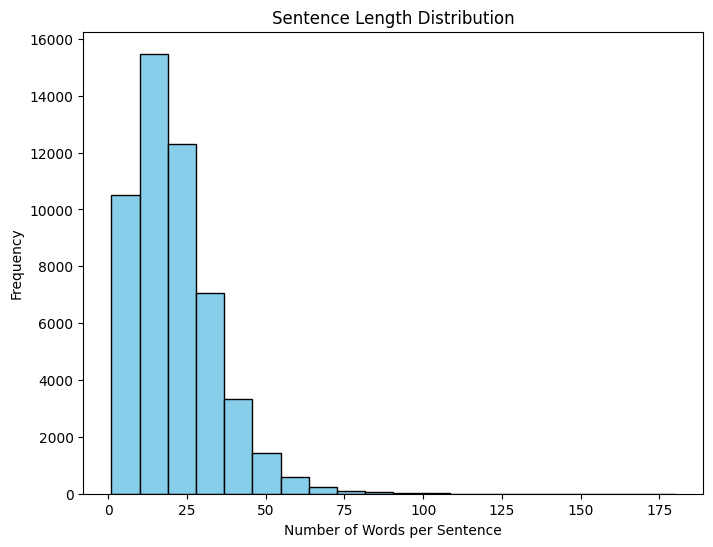

In [104]:
# Visualize the distribution of sentence lengths
plt.figure(figsize=(8, 6))
df['sentence_length'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

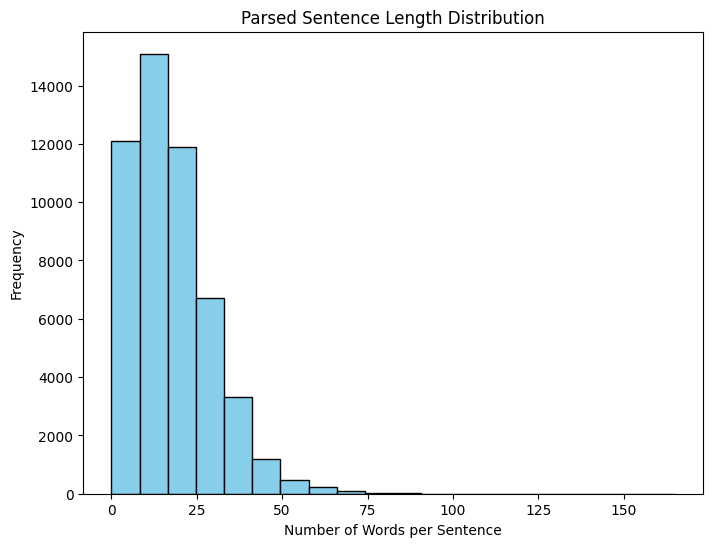

In [110]:
# Visualize the distribution of sentence lengths
plt.figure(figsize=(8, 6))
df['parsed_sentence_length'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title("Parsed Sentence Length Distribution")
plt.xlabel("Number of Words per Sentence")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

### Observation: 

1. No. of words in the first bin decreased and are closer to 10000 instead of 12000 after preprocessing

In [106]:
# Create a list of dictionaries where each dictionary represents a word-tag pair.
records = []
for sentence in df['parsed_sentence']:
    for word, tag in sentence:
        records.append({'word': word, 'tag': tag})

# Create a new DataFrame from the records.
df_words = pd.DataFrame(records)
print(df_words)

            word    tag
0             pm   NOUN
1            the    DET
2       industry   NOUN
3           have   VERB
4            say   VERB
...          ...    ...
899536       and  CCONJ
899537     older    ADJ
899538       men   NOUN
899539         b    ADJ
899540         w    ADJ

[899541 rows x 2 columns]


In [107]:
# Check basic information and types
print("Dataset Info:")
df_words.info()

# Summary statistics
print("\nDataset Summary Statistics:")
print(df_words.describe(include='all'))

# Check for missing values
print("\nMissing Values:")
print(df_words.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899541 entries, 0 to 899540
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   word    899541 non-null  object
 1   tag     899541 non-null  object
dtypes: object(2)
memory usage: 13.7+ MB

Dataset Summary Statistics:
          word     tag
count   899541  899541
unique   35988      15
top        the    NOUN
freq     60903  238844

Missing Values:
word    0
tag     0
dtype: int64


Length of tag distribution: 15

Tag Frequency Distribution:
tag
NOUN     238844
VERB     151350
ADP      124765
DET      115502
ADJ       76492
ADV       48887
PRON      48510
CONJ      27045
PROPN     18775
PRT       18667
AUX       12562
PART       7438
CCONJ      6326
SCONJ      3666
INTJ        712
Name: count, dtype: int64


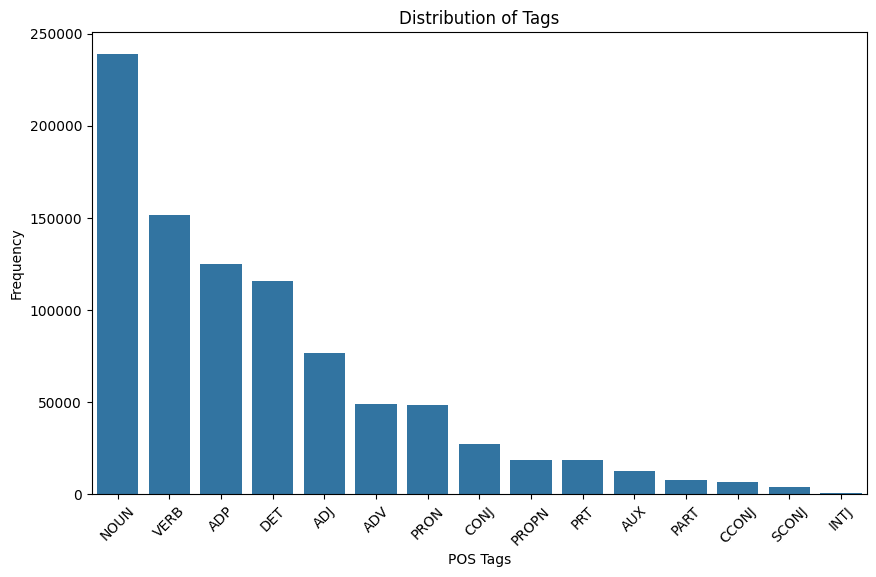

In [108]:
# Count the frequency of each tag
tag_distribution = df_words['tag'].value_counts()
print("Length of tag distribution:", len(tag_distribution))
print("\nTag Frequency Distribution:")
print(tag_distribution)

# Plot the distribution of tags
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=tag_distribution.index, y=tag_distribution.values)
plt.title("Distribution of Tags")
plt.xlabel("POS Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

2. No. of '.' has gone to zero


Top 10 Most Frequent Words:
word
the     60903
of      31305
be      28666
and     25256
to      24229
a       20815
in      19350
have    10040
that     9766
for      9047
Name: count, dtype: int64


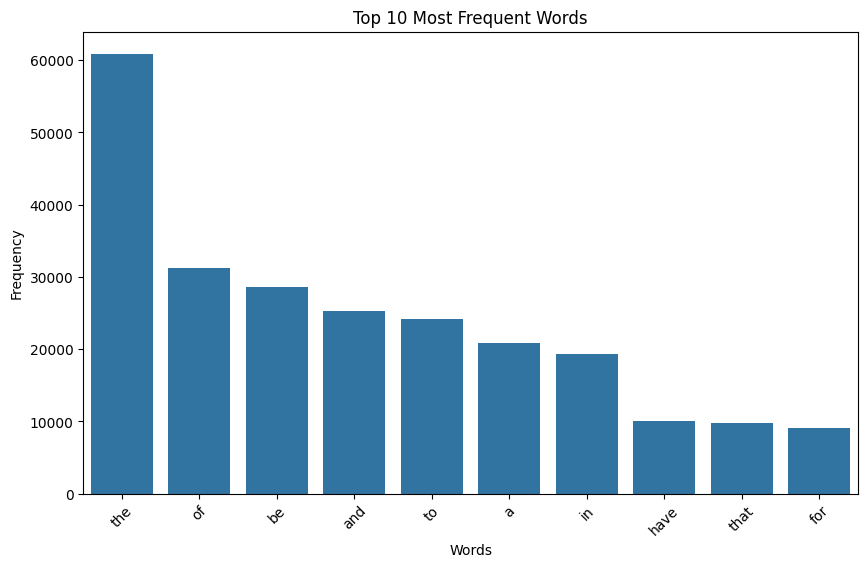

In [109]:
# Count the frequency of words
word_frequency = df_words['word'].value_counts()
print("\nTop 10 Most Frequent Words:")
print(word_frequency.head(10))

# Plot the top 10 most frequent words
plt.figure(figsize=(10, 6))
sns.barplot(x=word_frequency.head(10).index, y=word_frequency.head(10).values)
plt.title("Top 10 Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

3. Lots of changes: 
    a. '`' and '.' go to zero
    b. No. of 'the' increases to 60,000
    c. 'be' and 'for' are now one of the top 10 common words which weren't there in the original graph
    

## Using HMM to solve the PoS tagging problem

#### Transition Probabilities
  
<ul>
  <li> Compute <i>P</i>(<i>tag</i><sub>t+1</sub> | <i>tag</i><sub>t</sub>): 
      the probability of transitioning from one tag to another.
  </li>
  <li> Formula:
      <i>P</i>(<i>tag</i><sub>t+1</sub> | <i>tag</i><sub>t</sub>) =
        <span >
            Count(<i>tag</i><sub>t+1</sub> given <i>tag</i><sub>t</sub>)
        </span>/
        Count(<i>tag</i><sub>t</sub>)
  </li>
</ul>

In [ ]:
# Compute transition probabilities P(tag2 | tag1)
transition_counts = defaultdict(lambda: defaultdict(int))
tag_counts = defaultdict(int)

for sentence in df['parsed_sentence']:
    prev_tag = None
    for _, tag in sentence:
        tag_counts[tag] += 1
        if prev_tag is not None:
            transition_counts[prev_tag][tag] += 1
        prev_tag = tag

# doing laplace smoothing to avoid zero probabilities and adding 1 to numerator and len(tags) to denominator for fair probability distribution 
transition_probs = {
    tag1: {tag2: (transition_counts[tag1][tag2] + 1) / (tag_counts[tag1] + len(tags))
           for tag2 in tags}
    for tag1 in tags
}

print("\nTransition Probabilities:\n", transition_probs)

<p style="font-size:16px">
Note:- Why Use Laplacian Smoothing in HMM?
<ul style="font-size:15px">
    <li> Avoids zero probabilities, preventing the Viterbi algorithm from breaking.
    <li> Encourages generalization, allowing the model to predict unseen sequences.
    <li> Prevents overfitting, distributing probability mass more fairly among possible transitions.
    <li> Handles sparse data, which is common in NLP and speech recognition.
</ul>
</p>

#### Emission Probabilities
  
<ul>
  <li> Compute P ( word | tag ) : 
      <i>the probability of a word being generated by a tag.</i>
  </li>
  <li> Formula:
      <i>P ( word | tag ) = Count(word,tag) / Count(tag)</i>
  </li>
</ul>

In [ ]:
# Compute emission probabilities P(word | tag)
emission_counts = defaultdict(lambda: defaultdict(int))

for sentence in df['parsed_sentence']:
    for word, tag in sentence:
        emission_counts[tag][word] += 1

emission_probs = {
    tag: {word: (emission_counts[tag][word] + 1) / (tag_counts[tag] + len(words))
          for word in words}
    for tag in tags
}

#### Initial Probabilities
  
<ul>
  <li> Compute <i>P</i>(<i>tag</i><sub>start</sub>)): 
      the probability of a tag starting the sentence.
  </li>
  <li> Formula:
      <i>P</i>(<i>tag</i><sub>start</sub>) =
        <span >
            Count(<i>tag</i><sub>start</sub>)
        </span>/
        Total sentences
  </li>
</ul>

In [ ]:
# Compute initial probabilities P(tag | start)
start_counts = defaultdict(int)
total_sentences = len(df['parsed_sentence'])

for sentence in df['parsed_sentence']:
    if sentence:  # Ensure the sentence is not empty
        first_tag = sentence[0][1]
        start_counts[first_tag] += 1

start_probs = {
    tag: (start_counts[tag] + 1) / (total_sentences + len(tags))
    for tag in tags
}

print("\nInitial Probabilities:\n", start_probs)

#### Viterbi Algorithm

<h style="font-size:14px">Now we are using Viterbi Algorithm to find the most likely sequence of hidden states in an HMM.</h>
<p style="font-size:14px">
    <i>V<sub>t</sub></i>(<i>tag</i>) =
        max<sub>prev_tag</sub> [ <i>V<sub>t-1</sub></i>(<i>prev_tag</i>) . P(tag | prev_tag) . P(word | tag) ]
</p>

In [ ]:
lexicon = {
    'the': 'DET',
    'a': 'DET',
    'an': 'DET',
    'this': 'DET',
    'i': 'PRON',
    'you': 'PRON',
    'they': 'PRON',
    'We': 'PRON',
    'he': 'PRON',
    'she': 'PRON',
    'it': 'PRON',
    'is': 'AUX',
    'was': 'AUX',
    'has': 'AUX',
    'but': 'CONJ',
    'and': 'CONJ',  
}

In [ ]:
def viterbi_algorithm(sentence, tags, transition_probs, emission_probs, start_probs):
    V = [{}]  # Viterbi matrix (list of dictionaries)
    backpointer = [{}]  # Backpointer matrix

    # **Lexicon-based heuristic for the first word**
    first_word = sentence[0].lower()
    first_tag = lexicon.get(first_word, None)  # Check if the word exists in the lexicon
    
    for tag in tags:
        if first_tag == tag:  # Give high probability if lexicon match
            V[0][tag] = 1.0
        else:
            V[0][tag] = start_probs.get(tag, 1e-6) * emission_probs[tag].get(first_word, 1e-6)
        
        backpointer[0][tag] = None
    
    # # Initialize the first column of the Viterbi matrix
    # for tag in tags:
    #     V[0][tag] = start_probs.get(tag, 1e-6) * emission_probs[tag].get(sentence[0], 1e-6)
    #     backpointer[0][tag] = None
    
    # Populate the Viterbi matrix
    for t in range(1, len(sentence)):
        V.append({})
        backpointer.append({})
        
        for tag in tags:
            max_prob, best_prev_tag = max(
                (V[t-1][prev_tag] * transition_probs[prev_tag].get(tag, 1e-6) * emission_probs[tag].get(sentence[t], 1e-6), prev_tag)
                for prev_tag in tags
            )
            V[t][tag] = max_prob
            backpointer[t][tag] = best_prev_tag
    
    # Backtrack to find the best sequence
    best_last_tag = max(V[-1], key=V[-1].get)
    best_tags = [best_last_tag]
    
    for t in range(len(sentence) - 1, 0, -1):
        best_tags.insert(0, backpointer[t][best_tags[0]])
    
    return best_tags

<p>Testing on sample sentence to check whether our algorithm working properly or not</p>

In [ ]:
# Sample sentence for demonstration
sample_sentence = ["This", "is", "a", "sample", "sentence", "."]

# Predict tags for the sample sentence using the Viterbi algorithm
predicted_tags_sample = viterbi_algorithm(sample_sentence, tags, transition_probs, emission_probs, start_probs)

# Print the sample sentence with predicted tags
print("Sample Sentence:", sample_sentence)
print("Predicted Tags:", predicted_tags_sample)

#### Evaluation of the HMM

<p>Applying the trained model on Testing dataset and evaluating the Model by giving the accuracy score and the confusion matrix</p>

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Function to predict tags for a given sentence using the Viterbi algorithm
def predict_tags(test_sentence, tags, transition_probs, emission_probs, start_probs):
    return viterbi_algorithm(test_sentence, tags, transition_probs, emission_probs, start_probs)

# Prepare the test data
test_sentences = df_test['parsed_sentence'].tolist()
true_tags = [[tag for _, tag in sentence] for sentence in test_sentences]

# Predict tags for each sentence in the test set
predicted_tags = [predict_tags([word for word, _ in sentence], tags, transition_probs, emission_probs, start_probs) if sentence else [] for sentence in test_sentences]

# Flatten the lists of true and predicted tags
true_tags_flat = [tag for sentence in true_tags for tag in sentence]
predicted_tags_flat = [tag for sentence in predicted_tags for tag in sentence]

# Calculate accuracy
accuracy = accuracy_score(true_tags_flat, predicted_tags_flat)
print(f"Model Accuracy: {accuracy:.3f}")
# Create a DataFrame for incorrectly predicted tags
incorrect_predictions = pd.DataFrame({
    'Word': [word for sentence in test_sentences for word, _ in sentence],
    'True_Tag': true_tags_flat,
    'Predicted_Tag': predicted_tags_flat
})

# Filter out the incorrect predictions
incorrect_predictions = incorrect_predictions[incorrect_predictions['True_Tag'] != incorrect_predictions['Predicted_Tag']]

# Display the first 10 incorrect predictions
print("\nFirst 10 Incorrect Predictions:")
print(incorrect_predictions.head(10))

# Display statistics of incorrect predictions
print("\nStatistics of Incorrect Predictions:")
print(incorrect_predictions.describe(include='all'))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_tags_flat, predicted_tags_flat, labels=tags)
print("\nConfusion Matrix:")
print(conf_matrix)

# Optionally, generate a classification report
class_report = classification_report(true_tags_flat, predicted_tags_flat, labels=tags)
print("\nClassification Report:")
print(class_report)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=tags, yticklabels=tags)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Tags')
plt.ylabel('True Tags')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
